# Predict Next Purchase

In [1]:
%matplotlib inline
import composeml as cp
import data

## Load Data

In [2]:
df = data.load_orders('data', nrows=100000)
df.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,3031,33120,2,1,Organic Egg Whites,86,16,dairy eggs,2555,prior,21,6,9,6.0
1,3031,27086,1,1,Half & Half,53,16,dairy eggs,2555,prior,21,6,9,6.0
2,5640,33120,9,1,Organic Egg Whites,86,16,dairy eggs,155,prior,15,2,0,28.0
3,5640,12384,6,1,Organic Lactose Free 1% Lowfat Milk,91,16,dairy eggs,155,prior,15,2,0,28.0
4,5640,47209,7,1,Organic Hass Avocado,24,4,produce,155,prior,15,2,0,28.0


In [3]:
def add_time(user):
    user.days_since_prior_order = user.days_since_prior_order.fillna(1)
    return user.groupby('order_id').days_since_prior_order.first()


## Generate Labels

### Create Labeling Function

In [3]:
def bought_product(df, product_name):
    purchased = df.product_name.eq(product_name).any()
    return purchased

### Construct Label Maker

In [4]:
lm = cp.LabelMaker(
    target_entity='user_id',
    time_index='order_time',
    labeling_function=bought_product,
    window_size='4w',
)

### Search Labels

In [5]:
lt = lm.search(
    df,
    product_name='Banana',
    num_examples_per_instance=100,
    verbose=True,
)
lt.head()

Elapsed: 00:03 | Remaining: 00:00 | Progress: 100%|██████████| user_id: 28000/28000 


,user_id,cutoff_time,bought_product
id,,,
0,23,2061-09-05 10:00:00,False
1,23,2061-10-02 10:00:00,False
2,23,2061-10-30 10:00:00,False
3,27,2016-11-04 08:00:00,False
4,66,2094-01-01 02:00:00,False


### Describe Labels

Label Distribution
------------------
False     1107
True        48
Total:    1155


Settings
--------
num_examples_per_instance                       100
minimum_data                                   None
window_size                  <4 * Weeks: weekday=6>
gap                          <4 * Weeks: weekday=6>


Transforms
----------
No transforms applied



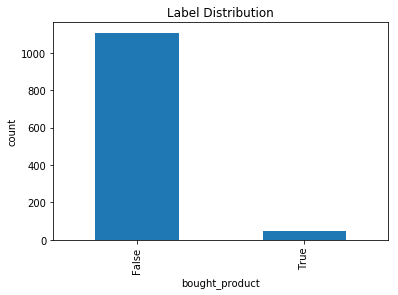

In [6]:
lt.describe()
lt.plot.distribution();